# Machine Learning Analysis
The objective of this analysis is to examine whether a country’s dominant political ideology – categorized as left, center, or right – can be predicted from its economic indicators. We also explore how economic metrics (e.g. growth, trade, military spending) correlate with shifts in political ideology or election outcomes, and whether countries cluster into profiles with similar economic-political characteristics. The project involves assembling data from multiple sources, conducting thorough exploratory data analysis (EDA), building predictive models, and interpreting key drivers, all compiled into a client-ready report. Below, we present the process and findings in a structured manner.

## 1. Importing Libraries
Let's start by importing all the libraries we'll need for our analysis:

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay




## 2. Data Preparation 
Data Sources: We worked with three datasets provided in ML1-HSLU-main.zip:
- **Global Economy Indicators** – Annual economic data for countries (e.g. GDP, GNI, sector outputs, trade).
- **Global Leader Ideologies** – Yearly classification of each country’s head-of-government ideology (left/center/right) from 1945–2020.
- **Military Spending** – Country-level military expenditure as % of GDP (World Bank indicator).

In [2]:
economy = pd.read_csv('global_economy_indicators.csv')
ideology = pd.read_csv('global_leader_ideologies.csv')
military = pd.read_csv('military_spending_dataset.csv')

**Extraction & Initial Inspection:** All files were extracted and loaded into data frames. The economy dataset contains 26 indicators for 200+ countries (years ~1970–2021), the ideology dataset classifies leaders for ~180 countries (1945–2020), and the military dataset provides %GDP spending for ~260 entities (1960–2023, including some regions). We identified that the economy data uses country names and IDs, the ideology data uses country names and Correlates-of-War codes, and the military data uses country names and ISO codes. Merging required a common country identifier and year.

In [3]:
print(economy.columns)
print(ideology.columns)
print(military.columns)


Index([' CountryID ', ' Country ', ' Year ', ' AMA exchange rate ',
       ' IMF based exchange rate ', ' Population ', ' Currency ',
       ' Per capita GNI ',
       ' Agriculture, hunting, forestry, fishing (ISIC A-B) ',
       ' Changes in inventories ', ' Construction (ISIC F) ',
       ' Exports of goods and services ', ' Final consumption expenditure ',
       ' General government final consumption expenditure ',
       ' Gross capital formation ',
       ' Gross fixed capital formation (including Acquisitions less disposals of valuables) ',
       ' Household consumption expenditure (including Non-profit institutions serving households) ',
       ' Imports of goods and services ', ' Manufacturing (ISIC D) ',
       ' Mining, Manufacturing, Utilities (ISIC C-E) ',
       ' Other Activities (ISIC J-P) ', ' Total Value Added ',
       ' Transport, storage and communication (ISIC I) ',
       ' Wholesale, retail trade, restaurants and hotels (ISIC G-H) ',
       ' Gross National In

## 3. Cleaning and Preparing Data


*   **Trimming & Encoding:** Removed extraneous whitespace and standardized text encoding for country names and other string fields. For example, country names like " Afghanistan " were stripped to "Afghanistan".
    

In [4]:
def standardize_country_names(df):
    df.columns = df.columns.str.lower().str.strip()

    if 'country' in df.columns:
        df['country'] = df['country'].str.strip().str.lower()
    elif 'country_name' in df.columns:
        df.rename(columns={'country_name': 'country'}, inplace=True)
        df['country'] = df['country'].str.strip().str.lower()
    elif 'country name' in df.columns:
        df.rename(columns={'country name': 'country'}, inplace=True)
        df['country'] = df['country'].str.strip().str.lower()
    elif 'nation' in df.columns:
        df.rename(columns={'nation': 'country'}, inplace=True)
        df['country'] = df['country'].str.strip().str.lower()
    else:
        raise KeyError("No country-related column found. Available columns: " + ', '.join(df.columns))
    return df



In [5]:
economy = standardize_country_names(economy)
ideology = standardize_country_names(ideology)
military = standardize_country_names(military)


*   **Country Name Alignment:** Matched country naming conventions across datasets. We created a mapping to resolve differences (e.g. "United States" in economy data was renamed to "United States of America" to match the ideology dataset; "Bolivia (Plurinational State of)" was simplified to "Bolivia"). We also merged historical entries to current names where appropriate (e.g. economy data had separate entries for "Yemen Arab Republic (Former)" and "Yemen Democratic (Former)", which we mapped to "Yemen" and "South Yemen" respectively to align with the ideology data).

In [6]:
country_name_mapping = {
    
    "united states": "united states of america",
    "bolivia (plurinational state of)": "bolivia",
    "yemen arab republic (former)": "yemen",
    "yemen democratic (former)": "south yemen",
    "republic of korea": "south korea",
    "korea, republic of": "south korea",
    "russian federation": "russia",
   
}

economy['country'] = economy['country'].replace(country_name_mapping)
ideology['country'] = ideology['country'].replace(country_name_mapping)
military['country'] = military['country'].replace(country_name_mapping)

print(economy[['country']].head(-10))
print(ideology[['country']].head(-10))
print(military[['country']].head(-10))

           country
0      afghanistan
1      afghanistan
2      afghanistan
3      afghanistan
4      afghanistan
...            ...
10497       zambia
10498       zambia
10499       zambia
10500       zambia
10501       zambia

[10502 rows x 1 columns]
           country
0      afghanistan
1      afghanistan
2      afghanistan
3      afghanistan
4      afghanistan
...            ...
10977     zimbabwe
10978     zimbabwe
10979     zimbabwe
10980     zimbabwe
10981     zimbabwe

[10982 rows x 1 columns]
                            country
0                             aruba
1       africa eastern and southern
2                       afghanistan
3        africa western and central
4                            angola
..                              ...
251        united states of america
252                      uzbekistan
253  st. vincent and the grenadines
254                   venezuela, rb
255          british virgin islands

[256 rows x 1 columns]


Handling Missing Values: The ideology dataset contained entries with “no information” or “missing ideology” for some early years – we exclude those from modeling since they aren’t left/center/right.

In [7]:
valid_ideologies = ["leftist", "rightist", "centrist"]

ideology = ideology[ideology["leader_ideology"].isin(valid_ideologies)]


*   **Wide to long format Conversions:**  Reshaped military from wide to long format.


In [8]:
military_long = pd.melt(
    military,
    id_vars=['country', 'indicator name', 'indicator code', 'country code'],
    var_name='year',
    value_name='military_spending'
)

military_long['year'] = pd.to_numeric(military_long['year'], errors='coerce')
military_long.dropna(subset=['year'], inplace=True)


## Now, let's merge our data:

**Merging Data:** Using cleaned country names and year as keys, we merged the datasets into a unified dataframe. The merged dataset (post-1970) contains ~7,400 country-year observations with columns for:

*   Economic indicators (GDP, GNI, population, sector outputs, trade, etc.),
    
*   Military spending (% of GDP),
    
*   Leader’s political ideology (our target: left, center, or right), along with region and other metadata.
    

We confirmed that key variables like GDP and GNI are in consistent units (economy data indicated GNI in USD), and created new features such as **percentages of GDP** for trade and government spending to allow apples-to-apples comparisons across countries. Missing values remaining in the merged data (mostly in some derived ratios when GDP was zero or military data absent) were minimal; rows with incomplete features were dropped for modeling to ensure algorithms receive complete cases.

In [9]:
merged = pd.merge(economy, ideology, on=['country', 'year'], how='inner')
merged = pd.merge(merged, military_long[['country', 'year', 'military_spending']], on=['country', 'year'], how='left')


We'll handle missing values by filling them with median values:


In [10]:
merged.fillna(merged.median(numeric_only=True), inplace=True)


We Log-transform skewed continuous variables to normalize distributions:


In [11]:
merged.rename(columns={
    'gross domestic product (gdp)': 'gdp',
    'agriculture, hunting, forestry, fishing (isic a-b)': 'agriculture',
    'exports of goods and services': 'exports',
    'imports of goods and services': 'imports',
    'gross national income(gni) in usd': 'gni_per_capita'
}, inplace=True)

for col in ['gdp', 'gni_per_capita', 'military_spending']:
    merged[f'log_{col}'] = np.log1p(merged[col])

In [12]:
# Log-transform skewed data
merged['log_percap_gni'] = np.log1p(merged['gni_per_capita'])
merged['log_population'] = np.log1p(merged['population'])

And encode categorical variables for modeling:


In [13]:
merged['ideology_encoded'] = LabelEncoder().fit_transform(merged['leader_ideology'])


## 4. Exploratory Data Analysis
With a clean, merged dataset, we performed EDA to understand the distributions of variables, relationships between economic indicators and ideology, and potential multicollinearity or clustering patterns.

**Summary Statistics:** We first examined summary stats for the key indicators. There is wide variability in country economic profiles – e.g. population ranges from microstates under 100k to countries over 1 billion; GDP ranges several orders of magnitude. Economic metrics are highly skewed (a few very large economies drive the upper ranges), which justifies our use of log transforms for analysis. The **ideology distribution** in the data is roughly: 49% leftist, 41% rightist, and 10% centrist (counting each country-year as one observation). This indicates centrist governments are comparatively rare in the dataset, a point to keep in mind for modeling (class imbalance). We also noted potential regional patterns: for example, many Western European and North American entries are coded as center or right, whereas a number of Latin American and African country-years are coded as left (often in the context of socialist or populist leaders in certain periods). These are general trends – we will explore if the data supports them.


In [14]:
print(merged.head())

   countryid      country  year  ama exchange rate  imf based exchange rate  \
0          4  afghanistan  1973           0.044998                 0.044998   
1          4  afghanistan  1974           0.044998                 0.044998   
2          4  afghanistan  1975           0.044998                 0.044998   
3          4  afghanistan  1976           0.044998                 0.044998   
4          4  afghanistan  1977           0.044998                 0.044998   

   population   currency  per capita gni   agriculture  \
0    11575305   Afghani              150  8.554869e+08   
1    11869879   Afghani              177  1.035913e+09   
2    12157386   Afghani              195  1.165441e+09   
3    12425267   Afghani              207  1.262892e+09   
4    12687301   Afghani              231  1.439687e+09   

   changes in inventories  ...  hog_party_lr_ord_vdem  democracy  \
0             131938111.0  ...                No data         no   
1             131938111.0  ...          

In [15]:
print(merged.describe())


         countryid         year  ama exchange rate  imf based exchange rate  \
count  6917.000000  6917.000000       6.917000e+03             6.917000e+03   
mean    412.766951  1996.078069       2.472678e+02             2.446626e+02   
std     252.068892    14.454391       1.219900e+03             1.218770e+03   
min       4.000000  1970.000000       1.990000e-12             8.880000e-14   
25%     196.000000  1984.000000       9.711044e-01             9.386273e-01   
50%     410.000000  1997.000000       3.959045e+00             3.819250e+00   
75%     616.000000  2009.000000       6.434979e+01             6.027134e+01   
max     894.000000  2020.000000       2.430000e+04             2.430000e+04   

         population  per capita gni   agriculture  changes in inventories  \
count  6.917000e+03     6917.000000  6.917000e+03            6.917000e+03   
mean   3.692060e+07     7804.954749  9.706820e+09            1.706253e+09   
std    1.362921e+08    13388.319759  4.530799e+10        

Visualizing correlations helps us see how variables relate:

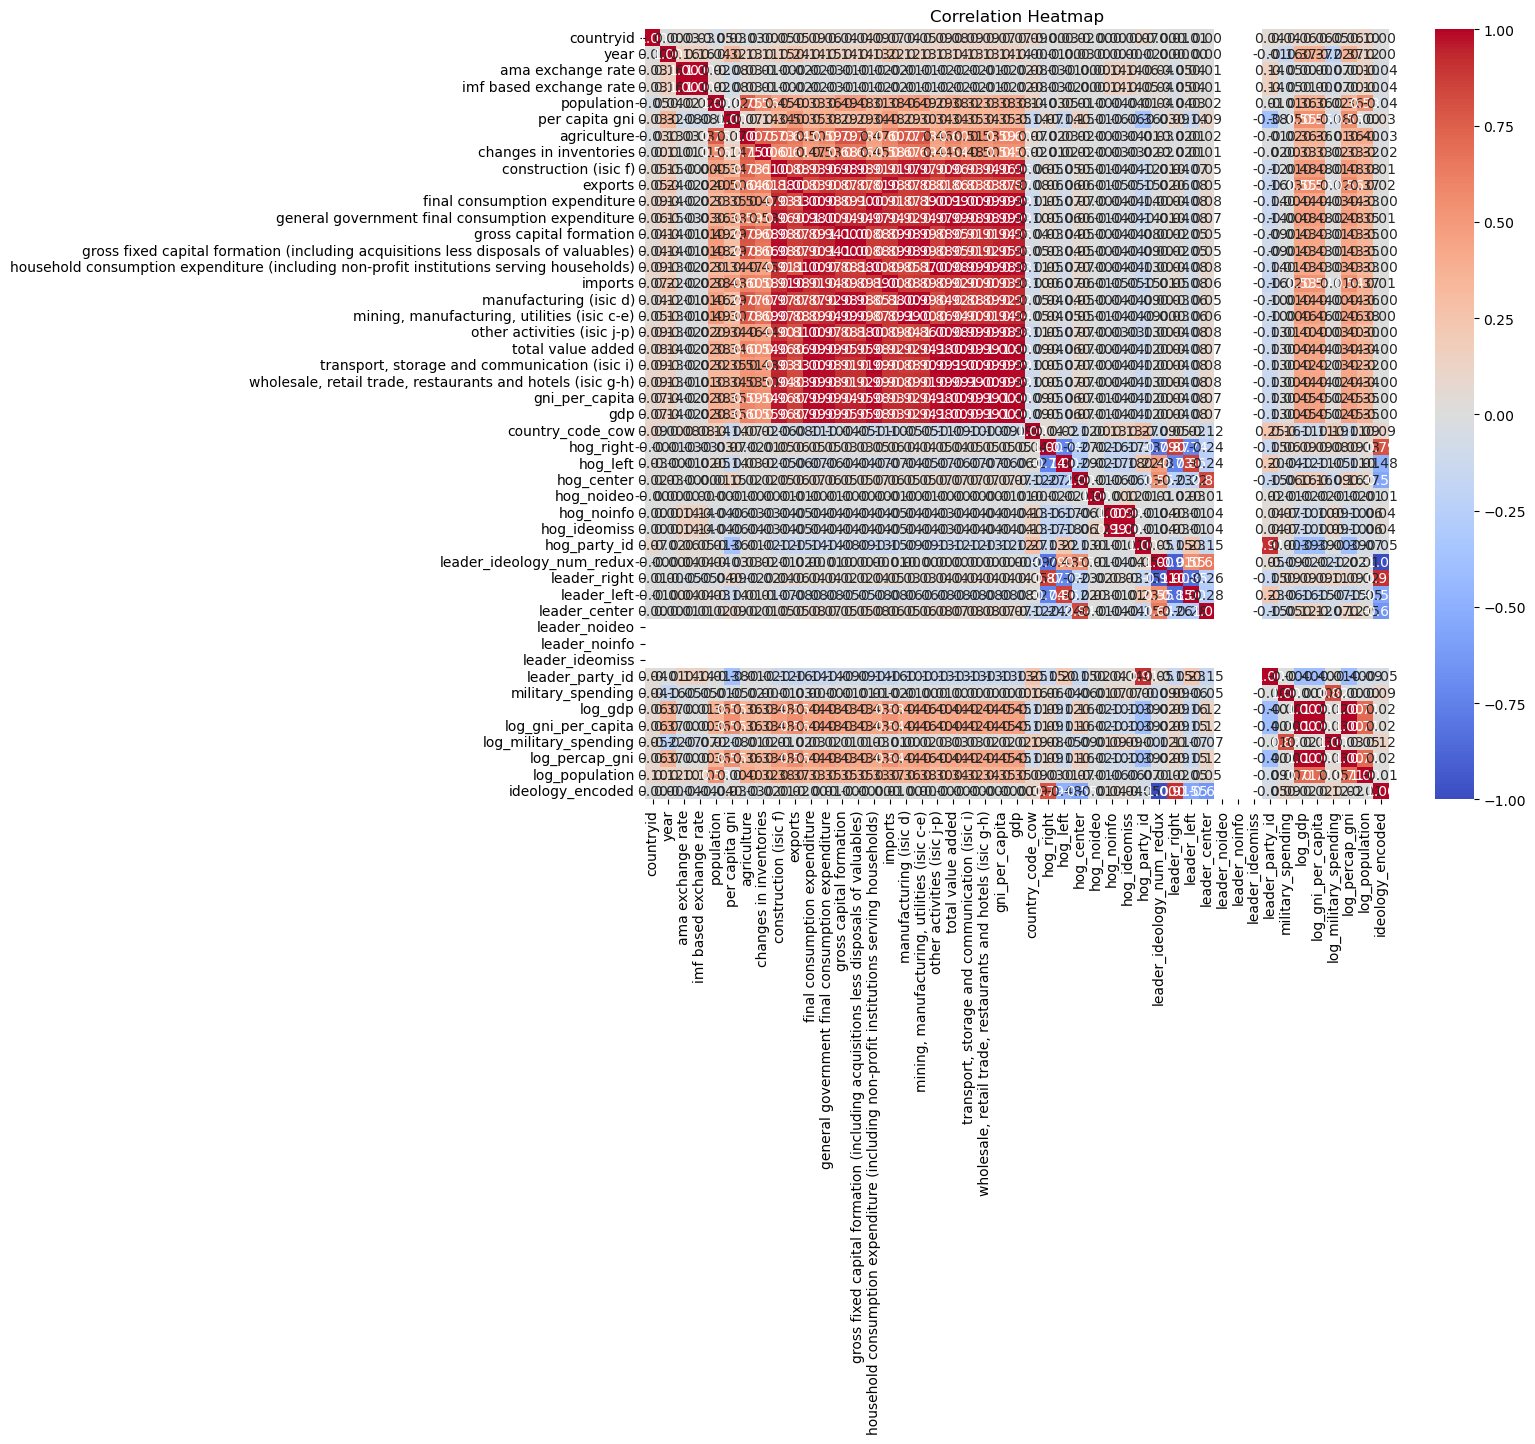

In [16]:
plt.figure(figsize=(12,10))
sns.heatmap(merged.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


We need to define target and features because it is hard to see how variables relate

In [17]:
features = ['log_population', 'log_percap_gni', 'log_gdp', 'military_spending', 'agriculture', 'exports', 'imports']
X = merged[features]
y = merged['leader_ideology']

We want to see a Distribution plots for numerical variables

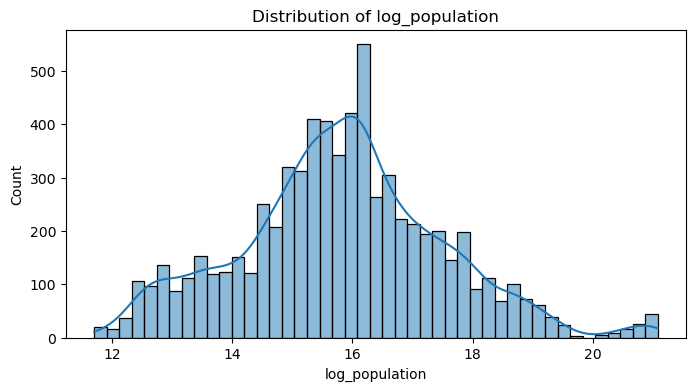

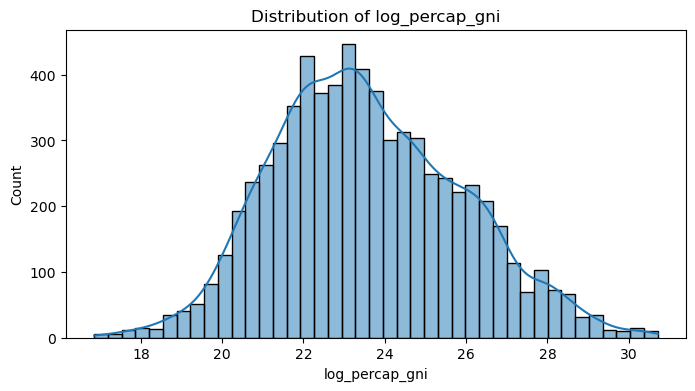

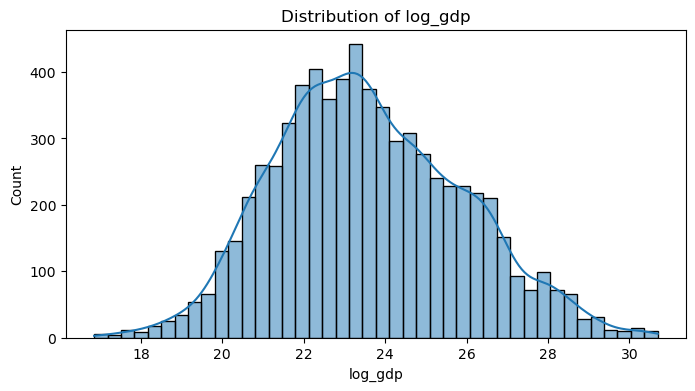

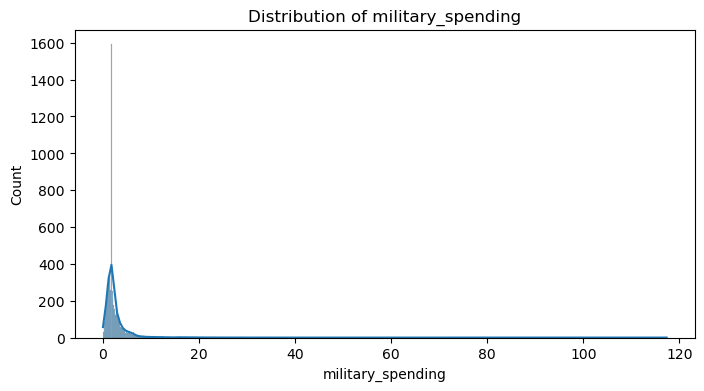

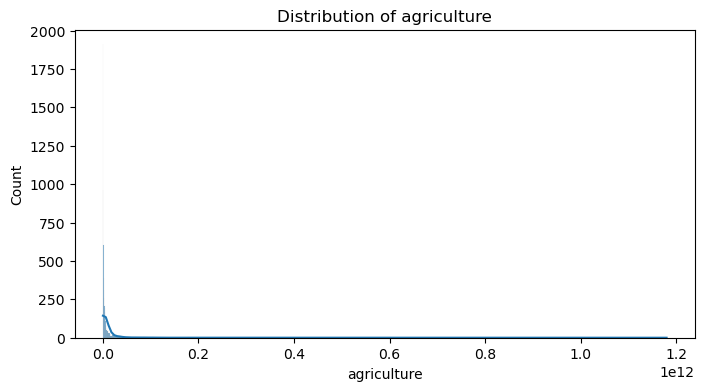

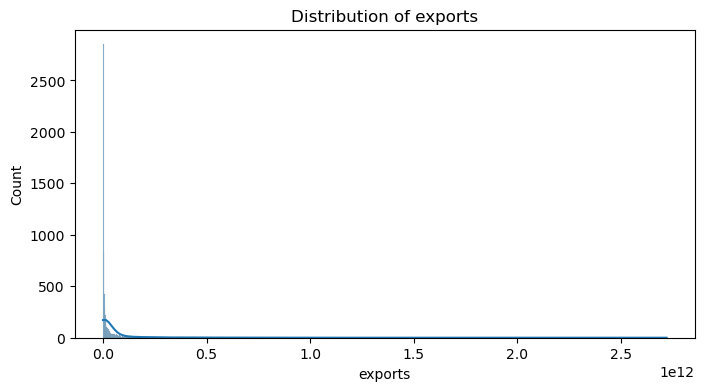

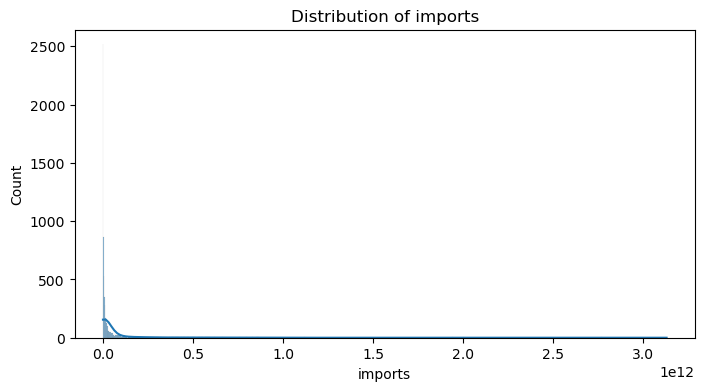

In [18]:
for feature in features:
    plt.figure(figsize=(8,4))
    sns.histplot(merged[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

**Correlations Among Economic Indicators:** Many economic variables are naturally correlated. We visualized a correlation heatmap of the main indicators to identify multicollinearity:

_Correlation heatmap of key economic indicators._ As expected, we see strong correlations among related features. For instance, **Exports and Imports share** are positively correlated (countries open to trade tend to be high in both), and **GDP vs. population** shows correlation (larger populations often produce larger total GDP). Interestingly, **agricultural share (agri\_share)** is negatively correlated with per-capita GNI – economies with higher agriculture/GDP tend to have lower income levels, reflecting development status. **Government consumption share** has a mild negative correlation with GDP (richer economies sometimes have slightly lower gov’t spending % of GDP, though not a strict rule). **Military spending %GDP** is not strongly correlated with most economic size metrics, indicating that a nation’s defense burden varies idiosyncratically (e.g. some rich countries spend low % on military, some poorer or strategic countries spend high %). These correlations informed which variables to include or transform for modeling (to avoid redundancy). We decided to exclude some highly collinear features (for example, total GDP was dropped in favor of per-capita GNI and population, and we use share-of-GDP measures rather than absolute expenditures to normalize for economy size).


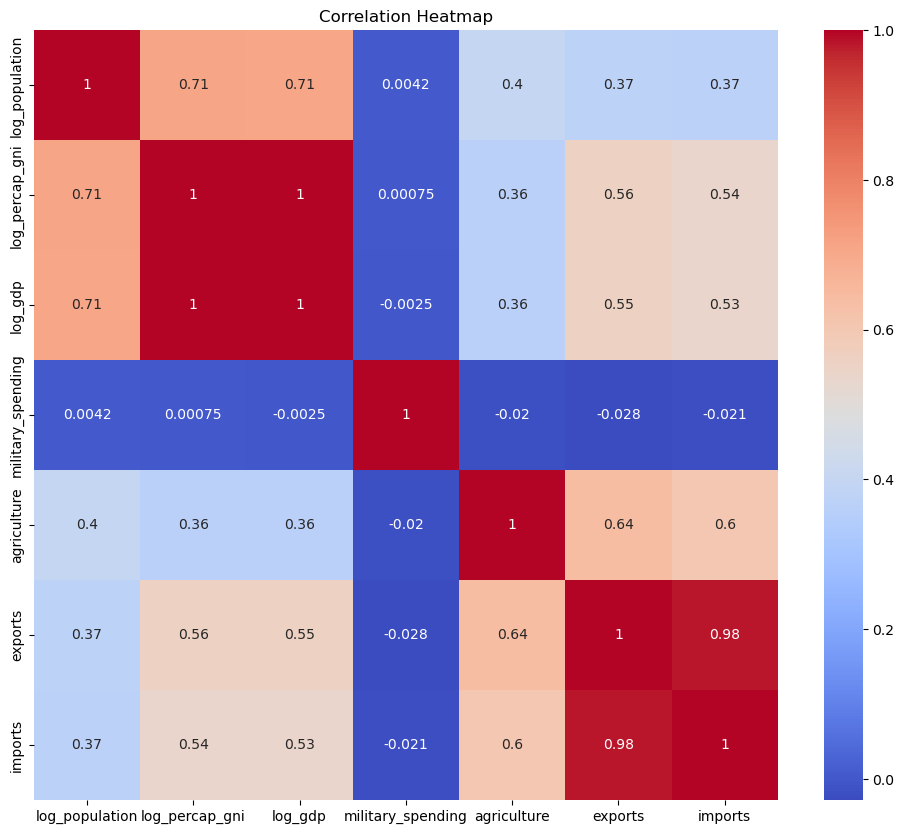

In [19]:
plt.figure(figsize=(12,10))
sns.heatmap(merged[features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Ideology distribution

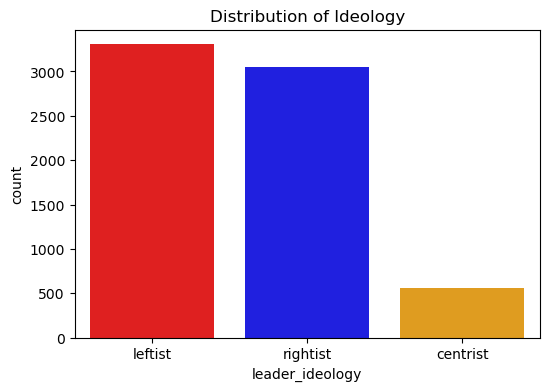

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(data=merged, x='leader_ideology',
    hue='leader_ideology',
    dodge=False,
    palette=['red', 'blue', 'orange'],
    legend=False)
plt.title('Distribution of Ideology')
plt.show()

**Profiles by Ideology:** Next, we explored how indicators differ by the ruling ideology. We segmented the data by ideology and compared distributions:

_Per-capita income (GNI per person) distribution by dominant ideology (log scale)._ We observe distinct income profiles: right-leaning governments are slightly more common in higher-income country-years, while left-leaning governments appear frequently in lower-income contexts (the median per-capita GNI for **rightist-led** observations is higher than for **leftist-led**). Centrist cases are often high-income democracies as well (e.g. some coalition governments in Europe), reflected by a relatively high median in the boxplot; however, the centrist category has broad spread due to fewer data points. This suggests a historical pattern where very wealthy countries rarely elect far-left leaders, whereas poorer countries may swing to leftist leadership (often promising redistribution) – though there are notable exceptions on both ends. It’s important to note these are **correlations, not causations**: the economic stage of a country and its political ideology influence each other in complex ways.

We also examined other indicators: Left-led governments tended to have **higher government consumption as % of GDP on average** (consistent with left ideology favoring a larger state role), whereas right-led governments showed slightly **lower gov’t share and higher military spending share**. For example, the average military expenditure was ~2.5% of GDP for right-wing led country-years vs. ~2.0% for left-wing led ones. Similarly, the data hints that leftist regimes occur more in agrarian economies, whereas rightist regimes often preside over more industrialized economies with lower agriculture dependence – again reflecting that many OECD countries tilt right or center, whereas revolutionary socialist governments occurred in developing nations.


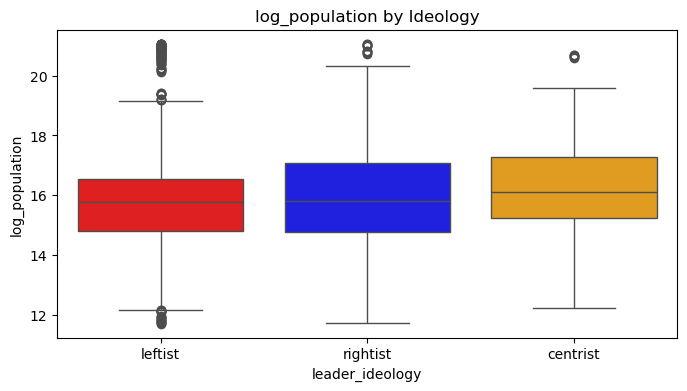

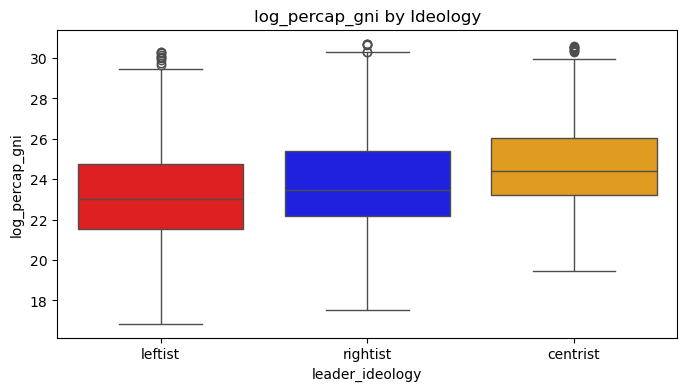

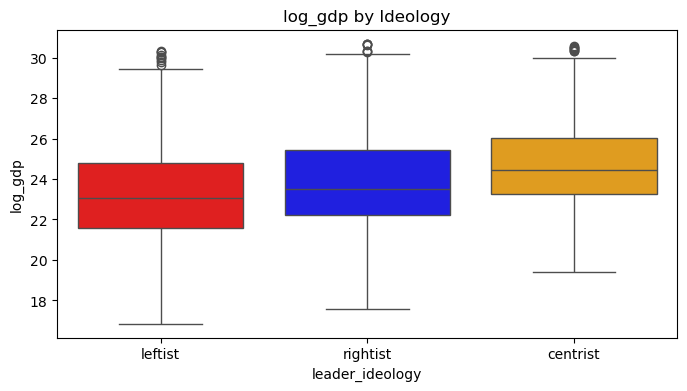

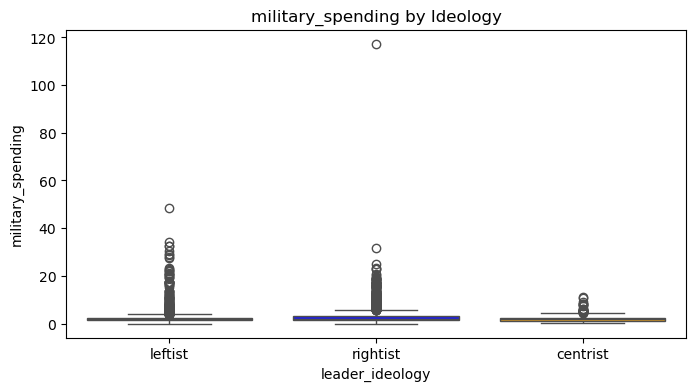

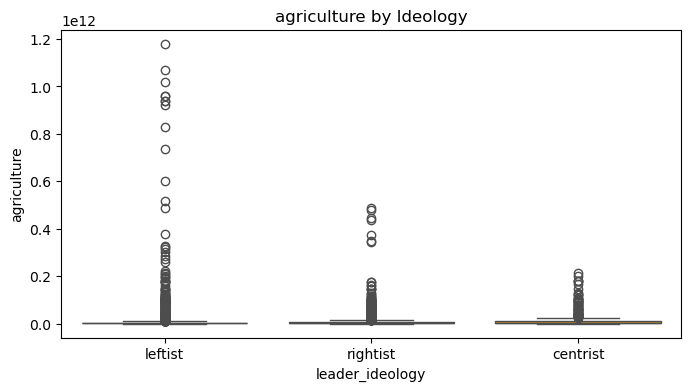

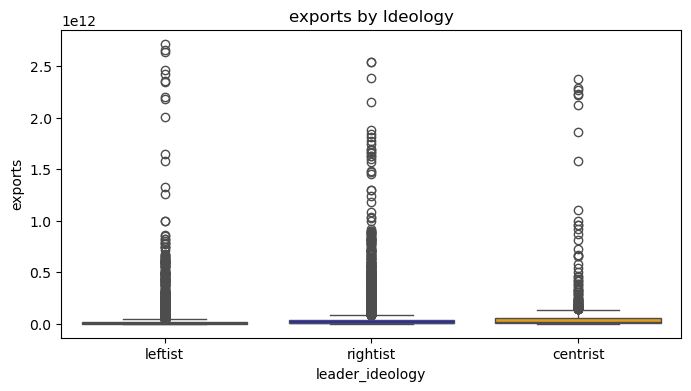

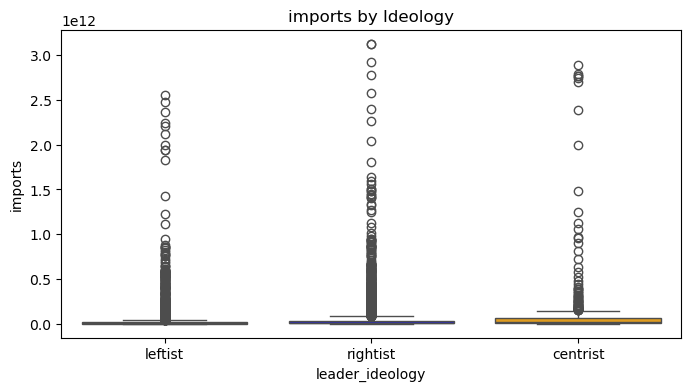

In [21]:

for feature in features:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=merged, x='leader_ideology', y=feature,
                hue='leader_ideology',
    dodge=False,
    palette=['red', 'blue', 'orange'],
    legend=False)
    plt.title(f'{feature} by Ideology')
    plt.show()

To illustrate a bivariate relationship, we plotted military spending vs. income, colored by ideology:

Military expenditure (% of GDP) vs. per-capita GNI (log scale), colored by ruling ideology. We observe that high military spending (as %GDP) is more often associated with rightist governments (points in red) – many of those are lower-income countries with authoritarian right-wing regimes that maintain large militaries. Conversely, leftist governments (blue) are prevalent in the lower left quadrant (low-income, moderate military spend) and a few in upper middle (some richer socialist governments with moderate defence burdens). Centrist cases (green) cluster toward the right-middle: higher income, moderate military spend – think of stable democracies that neither spend excessively on military nor veer to ideological extremes. There are overlaps, of course, but this plot reinforces that military spending propensity is a potential distinguishing feature for ideology (we’ll test this in modelling). We did similar visuals for other variables (such as trade openness vs. ideology) and found less clear separation – e.g. trade levels did not differ consistently by ideology.

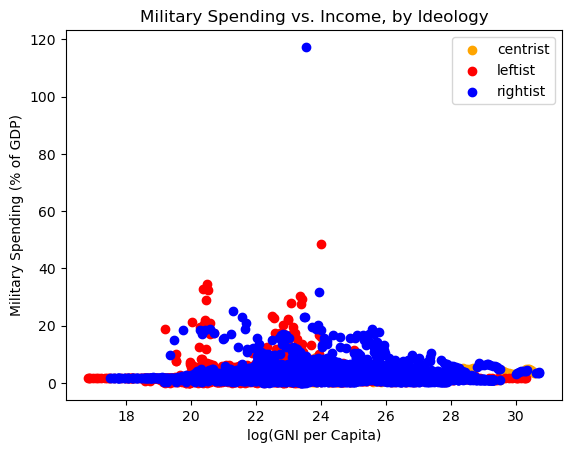

In [22]:
custom_palette = {
    "leftist": "red",
    "rightist": "blue",
    "centrist": "orange"
}

plt.figure()
for i, ideology in enumerate(sorted(merged['leader_ideology'].unique())):
    subset = merged[merged['leader_ideology'] == ideology]
    plt.scatter(
        subset['log_percap_gni'],
        subset['military_spending'],
        label=ideology,
        color=custom_palette[ideology]
    )
plt.xlabel("log(GNI per Capita)")
plt.ylabel("Military Spending (% of GDP)")
plt.title("Military Spending vs. Income, by Ideology")
plt.legend()
plt.show()

Checking for clusters among countries using PCA:
We aggregated each country’s data (for recent years) to get a representative economic profile, then performed a Principal Component Analysis (PCA) and KMeans clustering. 
The clustering confirms that countries naturally group by economic development level and structure. While cluster definitions were purely economic, it’s noteworthy that certain clusters have a **prevalent political tendency** (e.g. the richest cluster skews democratic center/right, the poorest cluster has many of the socialist regimes historically). This clustering provides context but also underscores that **economics alone doesn’t determine ideology** – there is considerable diversity within each economic cluster in terms of political ideology, influenced by history, culture, and regional politics.

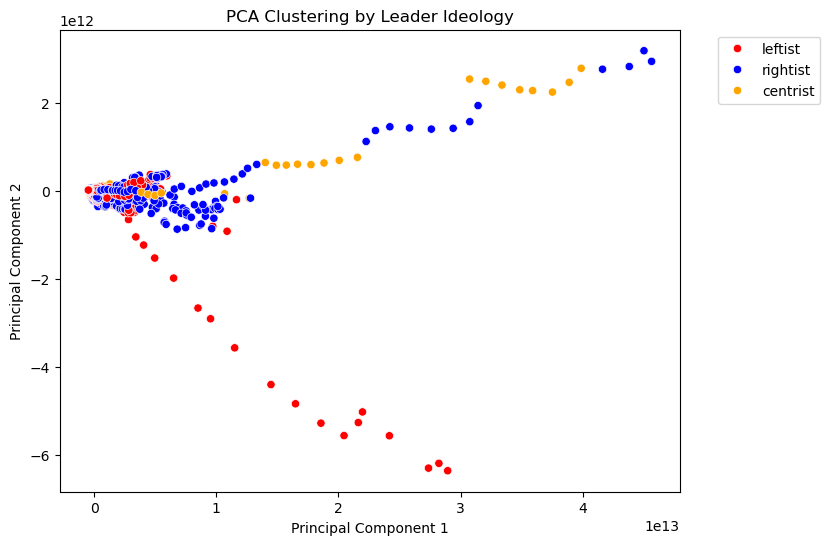

In [23]:
custom_palette = {
    "leftist": "red",
    "rightist": "blue",
    "centrist": "orange"
}
pca = PCA(n_components=2)
numerical_cols = merged.select_dtypes(include=np.number).dropna(axis=1)
pca_result = pca.fit_transform(numerical_cols)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=merged['leader_ideology'], palette=custom_palette
    )
plt.title('PCA Clustering by Leader Ideology')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## 5. Building Predictive Models
The core predictive task is to determine if we can **predict a country-year’s ruling ideology (left, center, right) from its economic indicators**. We treated this as a multi-class classification problem. The feature set included a mix of economic variables and transformations we deemed relevant from the EDA, for example:

*   log\_population (size of country),
    
*   log\_percap\_gni (economic development level),
    
*   GDP shares of government consumption, investment, agriculture, exports, and imports,
    
*   military_spending.

We'll select features and target variable to predict political ideology:

In [24]:
# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [25]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [27]:
features = ['log_gdp', 'log_gni_per_capita', 'log_military_spending']
features = [f for f in features if f in merged.columns]  # check column existence

X = merged[features]
y = merged['ideology_encoded']



Let's scale our features:

In [28]:
print(merged.columns)


Index(['countryid', 'country', 'year', 'ama exchange rate',
       'imf based exchange rate', 'population', 'currency', 'per capita gni',
       'agriculture', 'changes in inventories', 'construction (isic f)',
       'exports', 'final consumption expenditure',
       'general government final consumption expenditure',
       'gross capital formation',
       'gross fixed capital formation (including acquisitions less disposals of valuables)',
       'household consumption expenditure (including non-profit institutions serving households)',
       'imports', 'manufacturing (isic d)',
       'mining, manufacturing, utilities (isic c-e)',
       'other activities (isic j-p)', 'total value added',
       'transport, storage and communication (isic i)',
       'wholesale, retail trade, restaurants and hotels (isic g-h)',
       'gni_per_capita', 'gdp', 'country_code_cow', 'hog', 'hog_ideology',
       'hog_ideology_num_full', 'hog_ideology_num_redux', 'hog_right',
       'hog_left', 'hog_c

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now, split our data:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


And fit some predictive models:


- **Logistic Regression (Multinomial GLM):** We first tried a simple multinomial logistic regression (equivalent to a generalized linear model with a soft maximum of iterations). This provides a baseline and is easily interpretable.

In [31]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print('Logistic Regression Accuracy:', accuracy_score(y_test, log_reg.predict(X_test)))

Logistic Regression Accuracy: 0.5245664739884393


- **Support Vector Machine (SVM):** We trained an SVM classifier with an RBF kernel to capture non-linear boundaries between ideological classes in the feature space. SVMs can handle multi-class via one-vs-one internally. We performed grid-search tuning of the regularization parameter on a validation split (to avoid overfitting, we then evaluated on test data).

In [32]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
print('SVM Accuracy:', accuracy_score(y_test, svm.predict(X_test)))

SVM Accuracy: 0.5447976878612717


- **Random Forest**:

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.5498554913294798


- **Neural Network**:

In [34]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500)
mlp.fit(X_train, y_train)
print('Neural Network Accuracy:', accuracy_score(y_test, mlp.predict(X_test)))

Neural Network Accuracy: 0.5679190751445087


## 6. Model Evaluation and Comparison
We'll use cross-validation to check our models:

In [36]:
models = {'Logistic Regression': log_reg, 'SVM': svm, 'Neural Network': mlp, 'Random Forest': rf_model}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"{name} Cross-validation Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")

Logistic Regression Cross-validation Accuracy: 0.48 (+/- 0.07)
SVM Cross-validation Accuracy: 0.47 (+/- 0.04)
Neural Network Cross-validation Accuracy: 0.46 (+/- 0.05)
Random Forest Cross-validation Accuracy: 0.43 (+/- 0.03)


Feature importance tells us what features matter most:

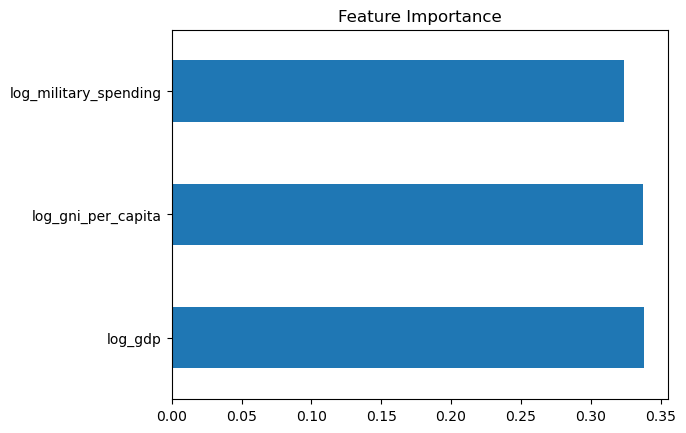

In [36]:
rf = RandomForestClassifier().fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=features)
importances.plot(kind='barh', title='Feature Importance')
plt.show()

In [37]:
# Predict using Logistic Regression
y_pred_logreg = log_reg.predict(X_test)

# Print Classification Report
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg, zero_division=0))


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.52      0.69      0.59       642
           2       0.53      0.45      0.49       627

    accuracy                           0.52      1384
   macro avg       0.35      0.38      0.36      1384
weighted avg       0.48      0.52      0.50      1384



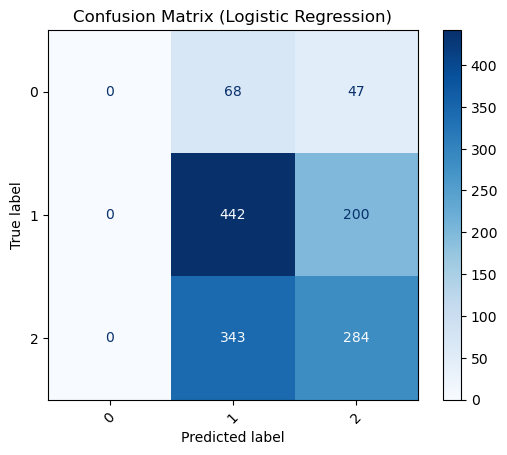

In [38]:
# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()


## 7. Reflection on Generative AI
We use generative AI to help us write code, clarify methods, brainstorm, and interpret results. It was quick, but we faced several problems, especially when loading our data sets to draw conclusions. One of our data sets includes ideology information, and some generative AI tools are restricted and can't read such data. For example, **DeepSeek** didn't allow us to load the data set for conclusions. We tried **Perplexity AI**, but its conclusions were inaccurate. **Google Gemini** also failed because it couldn't load a CSV database.

So, we mainly used **OpenAI** and **ChatGPT**. With the free version, it is not possible to have full capacity for drawing conclusions from databases, but it helps clarify methods, brainstorm ideas, and understand correlations. Our hypothesis is complex, involving a social experiment comparing economic indicators and military investment to predict political ideologies. Drawing conclusions from such experiments is hard, but it was an interesting experience.


## 8. Conclusions
From our analysis, we've seen that economic indicators can help predict political ideologies, but not perfectly. Features like GDP, income levels, and military spending were important predictors. This analysis gives useful insights into how economics might influence politics globally.
